# Generalized linear models
## Marcel Nonnenmacher, Jan-Mathis Lückmann, Pedro Goncalves, Jakob Macke

> One of the central problems in systems neuroscience is that of characterizing the functional relationship between sensory stimuli and neural spike responses. Investigators call this the neural coding problem, because the spike trains of neurons can be considered a code by which the brain represents information about the state of the external world. One approach to understanding this code is to build mathematical models of the mapping between stimuli and spike responses; the code can then be interpreted by using the model to predict the neural response to a stimulus, or to decode the stimulus that gave rise to a particular response. [(Pillow, 2007)](http://pillowlab.princeton.edu/pubs/Pillow_BBchap07.pdf)

Here, we will build probabilistic models for the response of a single neuron, starting from a simple model, that we will then extend. Conditional on a stimulus $x$ and model parameters $\theta$ we will model the probability of a neural reponse $y$, i.e., $p(y|x, \theta)$. Our central goal will be to find model parameters $\theta$ such that the $p(y|x,\theta)$ is a good fit to a dataset of stimulus-response pairs we observed, $\mathcal{D} = \{ (x_k,y_k) \}_{k=1}^K$. 


### Goals of these exercises

Central to inferring the best fitting parameters will be the likelihood function of the model. The simplest method goes by simply maximizing the likelihood using its gradient with respect to the model parameters (a technique called maximum likelihood estimation, MLE). You will learn to incorporate prior knowledge on the parameters, which leads to a method called maximum a posteriori (MAP). Finally, you will learn automatic differentiation (AD) which --- as the name suggests --- provides a automatic way to calcuate gradients of an objective function (here: the likelihood of parameters given the data). AD is a central ingredient to machine learning methods that are becoming increasingly popular.

### Assumptions and notation

Throughout this tutorial, we will adopt the following conventions:

- $T$ is the number of time bins within one trial; $t$ always specifies a time bin;
- $K$ is the number of trials in the experiment; $k$ always identifies a trial;
- to make the notation lighter, we will sometimes drop the subscript $k$;
- $\hat{\pi}(\cdot)$ indicates an unnormalized probability, and $\pi(\cdot)$ the same probability normalize to integrate to 1;
- $\mathcal{L}(\boldsymbol{\theta}) = p(\mathbf{y}\, |\, \boldsymbol{\theta})$ is the likelihood of the vector of parameters $\boldsymbol{\theta}$ for the (fixed) data $\mathbf{y}$.

For all models we consider, we assume that time is discretized in bins of size $\Delta$. Given $z_t$, the instantaneous *input rate* of a neuron at time $\Delta \cdot t$, the spike counts $y_t$ are assumed to be independent, and distributed according to

$\begin{equation}
    y_t \sim \mathrm{Poisson}\big(\eta(z_t)\big)
\end{equation}$

where  $\eta(\cdot)$ is corresponding canonical link function (here, we will always use $\eta(\cdot) = \exp(\cdot)$ for Poisson). We further assume that there is a linear dependence between $z_i$ and a set of external covariates $\mathbf{x}_t$ at time $t$, i.e. $z_t = \boldsymbol{\theta}^\top \mathbf{x}$, and $\boldsymbol{\theta}$ is a vector of parameters which fully characterizes the neuron.

Experiments are composed of $K$ trials, each subdivided into $T$ bins. 

Note, and in contrast to the lectures, we assume that the rate $\mu_t$ is already 'per bin size', i.e. the expected number of spikes is $\mu$ (and not $\mu\Delta$, as we had in lectures).

For a Poisson neuron, the probability of producing $n$ spikes in an interval of size $\Delta$ is given by 

$\begin{align}
P(y_t=n| \mu)= \frac{\mu^n e^{-\mu} }{n!}
\end{align}$


## Exercise 1 (from lectures)

Assume that you have spike counts $n_1$ to $n_K$ from $K$ trials, calculate the maximum likelihood estimate (MLE) of $\mu$.


## LNP model

The stimulus $\mathbf{u}_t$ is a white noise sequence, and the input rate is:

$\begin{equation}
    z_t = \mathbf{\beta}^\top \mathbf{u}_{t-\delta{}+1:t} + b = \boldsymbol{\theta}^\top \mathbf{x}
\end{equation}$,

i.e. $z_t$ is the result of a linear filter $\beta$ applied to the recent stimulus history $\mathbf{u}_{t-\delta{}+1:t}$, plus some offset $b$. This results in a vector of covariates at time $t$
$\mathbf{x}_{kt} = \big[1, \mathbf{u}_{kt-\delta{}+1},\ldots, \mathbf{u}_{kt} \big]^\top$ for temporal filter length $\delta \in \mathbb{N}$. Note that we can deal with any form of input in the second and third column of $\mathbf{x}_{kt}$, not just white noise.

The vector of parameters is $\boldsymbol{\theta} = \left[b, \beta^\top \right]^\top$.



### Simulating data from the model

Next, we  will want to generate data using this model. Execute the following code cell, which will load some functions you will need throughout the session.

In [1]:
import numpy as np

%run -i helpers.ipynb

The following cell generates a matrix $\mathbf{x}$ as specified above.

In [6]:
binsize = 0.001  # seconds
T = 10000        # 1s trials
K = 10  # number of trials
nbins = T*K

delta = 10       # length of temporal filter

# stimulus
U = np.random.normal(size=nbins)

def toyDesignMatrix(U=U, T=T, K=K):    
    nbins = T*K
    X = np.zeros((delta+1, nbins))

    X[0,:] = 1.       # bias
    if delta > 0:
        X[1, :] = U   # instantaneous input
    for i in range(1,delta):
        X[i+1, i+1:] = U[:-(i+1)]

    return X

X = toyDesignMatrix()

Next, we define $\mathbf{\theta}$.

In [7]:
# ground-truth vector of parameters
b = -6  # controls the offset and hence overall firing rate
beta = np.cos( np.linspace(0, PI, delta))
theta = np.hstack([b, beta])

Given `X` and `theta`, we want to generate sample spike trains. In the following cell, we do so by just using 

In [8]:
ys = []
for k in range(10):
    y, fr = toyModel(X, theta)  # spike train, firing rate
    ys.append(y)

... plotting spike rasters and PSTH:

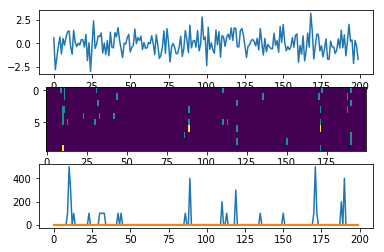

In [9]:
plt.subplot(311)
plt.plot(U[:200])
plt.subplot(312)
plt.imshow(np.asarray(ys)[:,:200], aspect=4, interpolation='None');
plt.subplot(313)
plt.plot(np.asarray(ys)[:, :200].mean(axis=0) / binsize);  # PSTH
plt.plot(fr[:200], linewidth=2);  # firing rate


### Optional: Try implementing the model yourself

(Optional): Above, you used an implementation of the model we provided. You can try implementing the model as stated above yourself. To do so, complete the following function template

In [7]:
def toyModelExercise(X, theta):
    # TODO: given stimulus and theta, return spikes and firing rate
    return y, fr

To check whether this model is correct, reproduce the PSTHs for both models and compare.



### MLE inference

#### Likelihood ####

The likelihood defines a model that connects model parameters to the observed data: 

$\begin{align}
\log \mathcal{L}(\boldsymbol{\theta}) &= \log p(\mathbf{y} | \boldsymbol{\theta}) = \log \bigg[ \prod_{k=1}^K \prod_{t=1}^T p(y_{kt} | b, \beta_1, \beta_2) \bigg] \\ &= \sum_{k=1}^K \sum_{t=1}^T \log p(y_{tk} | b, \beta_1, \beta_2) = \sum_{k=1}^K \sum_{t=1}^T \big[ z_{tk} y_{tk} - \mathrm{e}^{z_{tk}} \big], 
\end{align}$

where as above $z_{tk} = \theta^\top \mathbf{x}_{tk} = b + \beta^\top \mathbf{u}_{tk-\delta{}+1:tk}$.

Large $\mathcal{L}$ for a given set of parameters $\theta$ indicates that the data is likely under that parameter set. We can iteratively find more likely parameters, starting from some initial guess $\theta_0$, by gradient ascent on $\mathcal{L}$.

For this model, the likelihood function has a unique maximum.


#### Gradients ####

**Exercise 1:** Using pen and paper, derive the gradient of the $\log \mathcal{L}$ with respect to $\mathbf{\theta}$.


### MLE parameter inference

We will now want to the use gradient you just derived to do parameter inference. For that, we will need to implement the functions `ll` and `dll` (the log-likelihood function and its derivative).

**Exercise 2.1: ** Implement `ll` and `dll` in the cell below. 

In [10]:
# say, we got a single spike train
y, fr = toyModel(X, theta)  # spike train, firing rate

def ll(theta):
    # TODO: implement log-likelihood function
    return NotImplemented

def dll(theta):
    # TODO: implement derivative of log-likelihood function wrt theta
    return NotImplemented

**Exercise 2.2**: Assume the true parameters that we used to generate the data, $\mathbf{\theta}^*$, were unknown. We want to recover $\mathbf{\theta}^*$ starting from an initial guess $\mathbf{\theta}_0$. Fill the gaps in the code block below. How good do you recover $\mathbf{\theta}^*$? What happens if you change `step_size`?

In [11]:
theta_true = theta.copy()
theta_initial = np.random.randn(len(theta))

print('theta_star : {}'.format(theta_true))
print('theta_0 : {}'.format(theta_initial))

def gradientAscent(theta_initial, step_size=0.0001, num_iterations=1000):
    theta_hat = theta_initial.copy()
    
    for i in range(0, num_iterations):
        # TODO: fix the next lines
        log_likelihood = ...
        gradient = ... 
        theta_hat = theta_hat + ...

    return theta_hat

theta_hat = gradientAscent(theta_initial)
print('theta_hat : {}'.format(theta_hat))

theta_star : [-6.          1.          0.93969262  0.76604444  0.5         0.17364818
 -0.17364818 -0.5        -0.76604444 -0.93969262 -1.        ]
theta_0 : [-0.86170838 -0.52051442  1.04976038 -0.58227439  1.09268153  0.7375664
 -0.94986715  0.0133238  -0.62592408 -1.86035052 -0.09161797]


TypeError: unsupported operand type(s) for +: 'float' and 'ellipsis'

## Extending the model

Our simple model assumed independent firing in each time-bin that only depends on the stimulus. In reality, we know that the activity of neurons depends also on their recent firing history. 

The GLM frameworks allows to flexibly extend our model simply by adding additional covariates and corresponding parameters, i.e. by adding columns to design matrix $\mathbf{X}$ and entries to parameter vector $\theta$. 

Let us try introducing the recent spiking history $\mathbf{y}_{kt-\tau}, \ldots, \mathbf{y}_{kt-1}$ as additional covariates.

The vector of covariates at time $t$ becomes
$\mathbf{x}_{kt} = \big[1, \mathbf{u}_{kt-\delta+1 \ : \ tk}, \mathbf{y}_{kt-\tau \ : \ tk-1}\big]^\top$, 

and we extend the vector of parameters as $\boldsymbol{\theta} = \left[b, \mathbf{\beta}^\top, \mathbf{\psi}^\top \right]^\top$, with history kernel $\mathbf{\psi} \in \mathbb{R}^\tau$ and history kernel length $\tau \in \mathbb{N}$.


**Question:** What other covariates could help improve our model?

### MLE Inference

**Exercise 3.1:** Write a function that implements the new design matrix $\mathbf{X}$ (now depends on data $\mathbf{y}$). Note that we provide a function `createDataset()` to generate data from the extended model with given parameter vector $\theta$.

In [ ]:
tau = 5  # length of history kernel (in bins)

psi = - 1.0 * np.arange(0, tau)[::-1]
theta_true = np.hstack((theta, psi))
y = createDataset(U, T, K, theta_true, delta)

def extendedDesignMatrix(y): 
    # TODO: implement design matrix X with 
    # X[kt,:] = [1, w*cos(t), w*sin(t), y_{kt-tau:kt-1}]
    return NotImplemented

X = extendedDesignMatrix(y) # you might have to re-run the cell defining ll() and dll() 
                             # to update the used design matrix X and data y

**Exercise 3.2:** Write down the gradients for the extended model. What changes from our earlier simpler model?

## MAP inference

The solution $\hat{\theta}$ obtained by gradient ascent on the log-likelihood depends on the data $\mathcal{D} = \{ (x_{tk}, y_{tk}) \}_{(t,k)}$. In particular for very short traces and few trials, this data only weakly constrains the solution. 
We can often improve our obtained solutions by adding prior knowledge regarding what 'good' solutions should look like. In probabilistic modeling, this can be done by introducing prior distributions $p(\theta)$ on the model parameters, which together with the likelihood $\mathcal{L}$ define a posterior distribution over parameters given the data $p(\theta | \mathbf{y})$, 

$$ \log p(\theta | \mathbf{y}) = \log p(\mathbf{y}|\theta) + \log p(\theta) - \log p(\mathbf{y}) = \mathcal{L}(\theta) + \log p(\theta) + const.$$

Maximum a-posterio (MAP) estimates parameters $\theta$ by gradient ascent on the (log-)posterior. 

We will assume zero-mean Gaussian priors on $\beta, \psi$, i.e. 
\begin{align}
p(\beta) &= \mathcal{N}(0, \Sigma_\beta) \\
p(\psi) &= \mathcal{N}(0, \Sigma_\psi).
\end{align}
We will not assume an explicit prior on $b$, which effectively assumes $b$ to be distributed 'uniformly' over $\mathbb{R}$.


### Gradients

Compared to maximum likelihood, MAP only requires adding the prior gradient:

\begin{align}
\frac{\partial}{\partial \theta} p(\theta|\mathbf{y}) =  \frac{\partial}{\partial \theta} \mathcal{L}(\theta) + \frac{\partial}{\partial \theta}p(\theta)
\end{align}


### Exercises

**Exercise 4: ** Derive the gradients for the prior. If you get stuck, or if you want to verify the solution, ask the tutors for help.

**Exercise 5:** Fill gaps in codeblock below.

In [ ]:
## priors

# select prior covariance for input weights
Sig_beta = np.eye(delta)                     

# select prior covariance for history kernel
ir = np.atleast_2d(np.arange(tau, 0, -1))
Sig_psi = np.exp(- np.abs(ir.T - ir)/5)  # assuming smoothness

# convenience
P_beta, P_psi = np.linalg.inv(Sig_beta), np.linalg.inv(Sig_psi)


## functions and gradients

def po(theta):
    # TODO: implement log-posterior density function
    return NotImplemented

def dpo(theta):
    # TODO: implement derivative of log-posterior density function wrt theta
    return NotImplemented

# Hint: it can be helpful to first derive the functions for the prior below: 

def pr(theta):
    # TODO: implement log-prior density function
    return NotImplemented

def dpr(theta):
    # TODO: implement derivative of log-prior density function wrt theta
    return NotImplemented

# leave as is
def ll(theta):
    z = np.dot(theta, X)
    return np.sum( y * z - link(z) )

# leave as is
def dll(theta):
    z = np.dot(theta, X)
    r = y - link(z)
    return np.dot(X, r)

**Exercise 6:** Numerical gradient checking -- use the code below to numerically ensure your gradients are correct

In [ ]:
from scipy import optimize

thrn = np.random.normal(size=theta_true.shape)
print(optimize.check_grad(ll, dll, thrn))
print(optimize.check_grad(pr, dpr, thrn))
print(optimize.check_grad(po, dpo, thrn))

**Exercise 7:** Do inference (WIP)

In [ ]:
data = createDataset(1000, 1, theta_true, omega)

# TODO: implement gradient ascent

## Automatic differentiation 

Instead of calculating the gradients w.r.t. the model parameters by hand, we can calculate them automatically. Our objective function consists of many elementary functions, each of which is differentiable. [Automatic differentiation (AD)](https://en.wikipedia.org/wiki/Automatic_differentiation) applies the chain rule to the expression graph of our objective to find the gradient. 

Here, we will use a Python library called `autograd` to find the gradient of our objective. AD is a central ingredient in libraries used for training artifical neural networks, including theano, TensorFlow and PyTorch.


### Installation

Install the [`autograd` package](https://github.com/HIPS/autograd) through your package manager. 

Depending on how things are set up on your machine, install `autograd` by `pip3 install autograd --user` or by `pip install autograd --user`. 

You might need to restart the notebook kernel in case the simple example which follows fails with an import error. If you restart the kernel, make sure to re-run the cells. You can do that by choosing `Kernel > Restart & Run All` from the menu.

### `autograd` by a simple example

In [ ]:
import autograd.numpy as np   # thinly-wrapped numpy
from autograd import grad     # the only autograd function you may ever need

def tanh(x):                  # Define a function
    y = np.exp(-x)
    return (1.0 - y) / (1.0 + y)

grad_tanh = grad(tanh)        # Obtain its gradient function

print('Gradient at x=1.0 (autograd) : {}'.format(grad_tanh(1.0)))

print('Gradient at x=1.0 (finite diff): {}'.format((tanh(1.0001) - tanh(0.9999)) / 0.0002))

In [8]:
ipython nbconvert exercises.ipynb --to pdf

SyntaxError: invalid syntax (<ipython-input-8-f42dcd6cf475>, line 1)

### Exercises

**Exercise 8**: Redo exercise 2 using `autograd`. To do so, go to the first code cell of the notebook. Instead of `import numpy as np` use `import autograd.numpy as np`. Restart the notebook kernel and run through the notebook from the beginning, till you get to the point where you implemented `dll`. Replace `dll` by a AD version that relies on the function `grad` (see simple example).

**Exercise 9:** Similar to the previous exercise, adapt the extended version of the model to rely on `autograd` for differentiation. 

**Exercise 10 (open ended)** : Come up with your own extensions to one of the models. 